In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from file_cache import *
from fastai.vision import *
from fastai.callbacks.hooks import *

# gc.collect()
def unet_learner( arch:Callable, pretrained:bool=False, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None,
                 n_classes=2, img_size = (224,224), in_channels = 1,
                 **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    "blur: do maxpolling or not"
    body = create_body(arch, pretrained, cut)
    model = to_device(models.unet.DynamicUnet(body, n_classes=n_classes, img_size=img_size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), 'cuda')
    #print(model.layers[0][0])
    #out_channels = model.layers[0][0].out_channels 
    #model.layers[0][0] = nn.Conv2d(in_channels, out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).cuda()
    #model.layers[0][0].in_channels = 1
    return model

# #model = unet_learner( models.resnet50, n_classes=2, img_size = (224,224) )
# #model(torch.rand(10,3,224,224).cuda()).shape
# #model(torch.rand(10,3,224,224).cuda()).shape

2020-05-23 22:51:40,277 util_log.py[153] INFO Start the program at:amax7, 127.0.1.1, with:Load module


File_cache: Adjust notebook work fold to:/share/felix/pj/brain_seg/


In [2]:
from torchvision import transforms
from torchvision import transforms as TF
class DataSet_brain(Dataset):

    def __init__(self, ds_type='train'):
        self.image_size = 256
        self.ds_type = ds_type
        
        df = self.get_df()

        if ds_type == 'train':
            print('========', ds_type)
            print(df.valid.value_counts())
            self.df = df.loc[df.valid == False]
        elif ds_type == 'valid':
            self.df = df.loc[df.valid == True]

#         self.transforms = transforms.Compose([transforms.ToTensor(),
#                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                       transforms.Resize(224)
#                      ])

    def transform(self, image, mask):
        #print(image.shape, mask.shape)
        # Resize
        resize_img = transforms.Compose([transforms.ToTensor(),
                                         #transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
                                         transforms.ToPILImage(),
                                         transforms.Resize((224,224)),
                                         transforms.ToTensor(),
                                    ])
        
        resize_label = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((224,224)),
                                 
                            ])
        image = resize_img(image)
        mask = resize_label(mask)
        mask = np.array(mask).astype(int)

        return np.array(image), mask 

    def get_p_cnt(self, file):
        label = nib.load(file).get_fdata()
        label = np.where(label>0, 1, 0)
        label = label.sum(axis=0).sum(axis=0)
        return label

    @lru_cache()
    def get_df(self):
        

        img_file_list = glob('/share/data2/body/brain/train/image/**/*.*', recursive=True)

        df = pd.DataFrame({'img_file':img_file_list})
        df['p_id_path'] = df.img_file.apply(lambda val: os.path.dirname(val))
        df['p_id'] = df['p_id_path'].rank(method='max').astype(int)
        df.sort_values('p_id')

        df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'label'))

        df['valid'] = df.p_id%5 ==1

        df.valid.value_counts()
        return df

    def __getitem__(self, index):
        img = self.df.img_file.iloc[index]
        #print(img)
        img = cv2.imread(img)
        #print(img)
        img = (img-img.min())/(img.max()-img.min())
        
        #slice_sn = self.df.slice_sn.iloc[index]-1
        #print(slice_sn)
   
        label = self.df.label_path.iloc[index]
        #print(label)
        label = cv2.imread(label)[:, :, 0]
        
        
        #print(img.dtype, label.dtype)
        #return img, label
        return self.transform(img.astype(np.float32), label.astype(np.uint8)) 

    def __len__(self):
        return len(self.df)

    
for sn, (a, b) in enumerate(DataSet_brain()):
    print('===',type(a), type(b), a.shape, b.shape, np.unique(b))
    if sn> 9: break
    
 

2020-05-23 22:51:44,718 utils.py[129] INFO Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-05-23 22:51:44,719 utils.py[141] INFO NumExpr defaulting to 8 threads.


======== train
False    602
True     209
Name: valid, dtype: int64
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0 1 2 3 4]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0 1 2 3]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0 1 2 3 4]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0 1 2]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0 1 2]
=== <class 'numpy.ndarray'> <class 'numpy.ndarray'> (3, 224, 224) (224, 224) [0 1 2]


(224, 224)


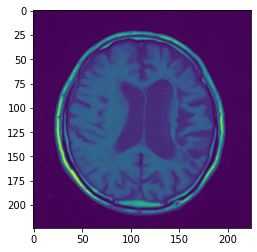

In [3]:
print(a[0].shape)
plt.imshow(a[0])

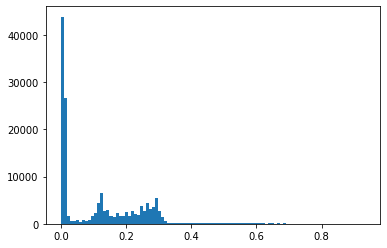

In [4]:
plt.hist(np.array(a).flatten(), bins=100)
plt.show()

In [ ]:
plt.imshow(b*50)
np.unique(b, return_counts=True)

(array([0, 1, 2]), array([46725,  1434,  2017]))

In [ ]:
def dice_multiply(logits, targets ):

    dice_list = edict()    
    batch_size, class_cnt = logits.shape[0], logits.shape[1]
    #class_list = range(class_cnt)
    
    dice_list = []
    for class_index in range(class_cnt):
        predict = logits.argmax(axis=1) 
        target  = targets==class_index
        
        predict = predict.view(batch_size, -1)
        target  = target.view(batch_size, -1)
        
        
        #print('======', predict.shape,  target.shape)
        #print(predict.shape, logits.shape, target.shape)
        inter = torch.sum(predict * target, dim=1)
        union = torch.sum(predict, dim=1) + torch.sum(target, dim=1)
        dice = (2. * inter + 1) / (union + 1)
        #print(dice)
        dice = dice.mean()
        #print(dice, inter, union)
        dice_list.append(dice)
    #print(dice_list)
    return  torch.Tensor(dice_list)


clss_cnt = 3
a = torch.Tensor(np.random.rand(2, clss_cnt, 224, 224)).cuda() 
b = torch.Tensor(np.random.randint(0,clss_cnt, (2, 224, 224))).cuda() 

tmp  = dice_multiply(a, b )
tmp

In [ ]:
a = torch.rand(30,5)

In [ ]:
a.mean(dim=1).mean(), a.mean()


In [ ]:
import os

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from functools import partial

class BrainModel(pl.LightningModule):

    def __init__(self, model=None, opt=None):
        super(BrainModel, self).__init__()
        self.unet = unet_learner( models.resnet50, n_classes=5, img_size = (224,224) ) 
        #self.loss_fn = DICELoss().cuda()
        #self.loss_fn = partial(F.cross_entropy, weight=torch.tensor([0.5, 1]).cuda())
        self.loss_fn = F.cross_entropy 
        self.opt = None

    def forward(self, x):
        # called with self(x)
        #print(x.shape)
        return self.unet(x)

    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        
        #print(y_hat.shape, y.shape, loss)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        import ipdb
        #ipdb.set_trace()
        return {'val_loss': self.loss_fn(y_hat, y ), 'dice': dice_multiply(y_hat, y)}

    def validation_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        import ipdb
        #ipdb.set_trace()
        dice = torch.stack([x['dice'] for x in outputs]) 
        dice_cls = dice.mean(dim=0)
        dice = dice_cls.mean()
        
        print({'eopch':self.current_epoch, f'val_loss': round(float(avg_loss),4), 'dice':dice_cls})
        
        tensorboard_logs = {'val_loss': avg_loss, 'dice':dice}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        print('test_step')
        x, y = batch
        y_hat = self(x)
        return {'test_loss': self.loss_fn(y_hat, y)}

    def test_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': logs, 'progress_bar': logs}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        if self.opt is None:
            self.opt = torch.optim.Adam(self.parameters(), lr=1e-4)   
        print('configure_optimizers', self.opt)
        
        return self.opt
#         from brain.schedule import OneCycleLR
        
#         scheduler = OneCycleLR(self.opt, num_steps=num_steps, lr_range=(0.1, 1.))
#         return [self.opt], [scheduler]


    def train_dataloader(self):
        # REQUIRED
        return DataLoader(DataSet_brain('train'), batch_size=8, )
        #return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(DataSet_brain('valid'), batch_size=2, )
        ##return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(DataSet_brain('valid'), batch_size=2,  )
        #return DataLoader(MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor()), batch_size=32)
        
        




In [ ]:
del brain_model, trainer

In [19]:
#Batch size 8
AdamW = partial(optim.Adam, betas=(0.9,0.99))

brain_model = BrainModel(opt=AdamW)

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1,
                     max_epochs=5,
                     weights_summary=None)    
trainer.fit(brain_model) 

RuntimeError: CUDA out of memory. Tried to allocate 288.00 MiB (GPU 0; 23.65 GiB total capacity; 22.35 GiB already allocated; 36.44 MiB free; 22.76 GiB reserved in total by PyTorch)

In [15]:
raise Exception()

Exception: 

In [15]:
# AdamW Optim
for i in range(1):
    print(i, '=='*10)
    AdamW = partial(optim.Adam, betas=(0.9,0.99))

    brain_model = BrainModel(opt=AdamW)

    # most basic trainer, uses good defaults (1 gpu)
    trainer = pl.Trainer(gpus=1,
                         max_epochs=5,
                         weights_summary=None)    
    trainer.fit(brain_model)  

0 ====================


2020-05-23 22:38:14,277 distrib_data_parallel.py[220] INFO GPU available: True, used: True
2020-05-23 22:38:14,279 distrib_data_parallel.py[268] INFO VISIBLE GPUS: 0


configure_optimizers Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)


{'eopch': 0, 'val_loss': 0.8608, 'dice': tensor([8.4236e-01, 1.1225e-02, 3.4791e-03, 1.9797e-04, 3.5087e-04])}


======== train
False    602
True     209
Name: valid, dtype: int64


{'eopch': 0, 'val_loss': 0.0377, 'dice': tensor([0.0020, 0.5133, 0.6244, 0.4690, 0.4461])}


{'eopch': 1, 'val_loss': 0.0345, 'dice': tensor([0.0039, 0.5502, 0.7707, 0.4862, 0.4728])}


{'eopch': 2, 'val_loss': 0.0223, 'dice': tensor([0.0036, 0.5644, 0.7305, 0.4423, 0.4387])}


{'eopch': 3, 'val_loss': 0.0156, 'dice': tensor([0.0042, 0.5848, 0.7474, 0.4341, 0.4312])}


{'eopch': 4, 'val_loss': 0.0129, 'dice': tensor([0.0038, 0.6001, 0.7881, 0.4599, 0.4511])}



In [12]:
#Original Score
brain_model = BrainModel( )

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1,
                     max_epochs=5,
                     weights_summary=None)    
trainer.fit(brain_model)  

2020-05-23 20:28:56,296 distrib_data_parallel.py[220] INFO GPU available: True, used: True
2020-05-23 20:28:56,297 distrib_data_parallel.py[268] INFO VISIBLE GPUS: 0


{'eopch': 0, 'val_loss': 10.2875, 'dice': tensor([1.4352e+00, 2.0023e-02, 1.6455e-02, 1.2386e-03, 8.8200e-04])}


======== train
False    602
True     209
Name: valid, dtype: int64


{'eopch': 0, 'val_loss': 0.0374, 'dice': tensor([0.0025, 0.5342, 0.6492, 0.4995, 0.4781])}


{'eopch': 1, 'val_loss': 0.0299, 'dice': tensor([0.0045, 0.5622, 0.6217, 0.4054, 0.4049])}


{'eopch': 2, 'val_loss': 0.0157, 'dice': tensor([0.0037, 0.5720, 0.7549, 0.4392, 0.4390])}


{'eopch': 3, 'val_loss': 0.0137, 'dice': tensor([0.0046, 0.5899, 0.7642, 0.4433, 0.4474])}


{'eopch': 4, 'val_loss': 0.0128, 'dice': tensor([0.0048, 0.5852, 0.7703, 0.4337, 0.4420])}



1